In [118]:
#Importing libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
from pandas import concat
from numpy import asarray
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import datetime
from statsmodels.tsa.tsatools import lagmat
from statsmodels.tsa.arima.model import ARIMA

# Data Import and Cleaning

In [119]:
%store -r df_cleaned
df = df_cleaned 

In [120]:
TS1 = df[(df['Plz'] == "['25', '24']")]
TS1_A2 = TS1[TS1['full'] == 'A2 -  geschreddert']
TS1_A1A2 = TS1[TS1['full'] == 'A1 & A2 -  geschreddert']
TS1_A2A3 = TS1[TS1['full'] == 'A2 & A3 -  geschreddert']

# Modelling - Train, test split

In [121]:
splitratio = 0.05
nobs = round(len(TS1_A1A2)*splitratio)
df_train, df_test = TS1_A1A2[0:-nobs], TS1_A1A2[-nobs:]

In [122]:
df_train.tail(10)

,week,wPreis,Plz,full,date
date,,,,,
2023-12-18,2023-51,6.450720,"['25', '24']",A1 & A2 - geschreddert,2023-12-18
2023-12-25,2023-52,8.000347,"['25', '24']",A1 & A2 - geschreddert,2023-12-25
2024-01-01,2024-01,8.175860,"['25', '24']",A1 & A2 - geschreddert,2024-01-01
2024-01-08,2024-02,15.229927,"['25', '24']",A1 & A2 - geschreddert,2024-01-08
2024-01-15,2024-03,13.620983,"['25', '24']",A1 & A2 - geschreddert,2024-01-15
2024-01-22,2024-04,15.224534,"['25', '24']",A1 & A2 - geschreddert,2024-01-22
2024-01-29,2024-05,14.944941,"['25', '24']",A1 & A2 - geschreddert,2024-01-29
2024-02-05,2024-06,13.757136,"['25', '24']",A1 & A2 - geschreddert,2024-02-05
2024-02-12,2024-07,17.343213,"['25', '24']",A1 & A2 - geschreddert,2024-02-12


In [123]:
df_test

,week,wPreis,Plz,full,date
date,,,,,
2024-02-26,2024-09,22.155904,"['25', '24']",A1 & A2 - geschreddert,2024-02-26
2024-03-04,2024-10,14.056574,"['25', '24']",A1 & A2 - geschreddert,2024-03-04
2024-03-11,2024-11,5.704197,"['25', '24']",A1 & A2 - geschreddert,2024-03-11
2024-03-18,2024-12,21.771781,"['25', '24']",A1 & A2 - geschreddert,2024-03-18
2024-03-25,2024-13,5.372211,"['25', '24']",A1 & A2 - geschreddert,2024-03-25
2024-04-01,2024-14,-2.297377,"['25', '24']",A1 & A2 - geschreddert,2024-04-01
2024-04-08,2024-15,1.815280,"['25', '24']",A1 & A2 - geschreddert,2024-04-08
2024-04-15,2024-16,5.515964,"['25', '24']",A1 & A2 - geschreddert,2024-04-15
2024-04-22,2024-17,10.971897,"['25', '24']",A1 & A2 - geschreddert,2024-04-22


# XGBOOST

In [124]:
from xgboost import XGBRegressor


In [125]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
 n_vars = 1 if type(data) is list else data.shape[1]
 df = pd.DataFrame(data)
 cols = list()
 # input sequence (t-n, ... t-1)
 for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
 # forecast sequence (t, t+1, ... t+n)
 for i in range(0, n_out):
    cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
# drop rows with NaN values
 if dropnan:
    agg.dropna(inplace=True)
 return agg.values

In [126]:

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
 return data[:-n_test, :], data[-n_test:, :]

In [127]:
# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
 # transform list into array
 train = asarray(train)
 # split into input and output columns
 trainX, trainy = train[:, :-1], train[:, -1]
 # fit model
 model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
 model.fit(trainX, trainy,verbose = True)
 # make a one-step prediction
 yhat = model.predict(asarray([testX]))
 return yhat[0]

## Walk-forward validation using XGBoost

Retraining model on updated training data, appended at every step to add the new value from test set.

In [128]:
# walk-forward validation for univariate data
def xgb_walk_forward_validation(data, n_test):
 predictions = list()
 direction_accuracies = list() 
 # split dataset
 train, test = train_test_split(data, n_test)
 # seed history with training dataset
 history = [x for x in train]
 # step over each time-step in the test set
 for i in range(len(test)):
 # split test row into input and output columns
    testX, testy = test[i, :-1], test[i, -1]
    # fit model on history and make a prediction
    yhat = xgboost_forecast(history, testX)
    # store forecast in list of predictions
    predictions.append(yhat)
    if i > 0:  # Direction accuracy is not applicable for the first prediction
            forecast_diff = yhat - predictions[-2]
            actual_diff = testy - test[i - 1, -1]
            direction_accuracy = int(np.sign(forecast_diff) == np.sign(actual_diff))
            direction_accuracies.append(direction_accuracy)

    # add actual observation to history for the next loop
    history.append(test[i])
    # summarize progress
    #print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
 # estimate prediction error
 mae = mean_absolute_error(test[:, -1], predictions)
 me = np.mean(predictions - test[:, -1])  # Mean Error
 rmse = mean_squared_error(test[:, -1], predictions, squared=False)
 overall_direction_accuracy = np.mean(direction_accuracies)

 # return mae, me, rmse ,test[:, -1], predictions, overall_direction_accuracy
 return {'mae':mae, 'me': me, 'rmse': rmse, 'expected':test[:, -1], 'predictions': predictions, 'direction_accuracy': overall_direction_accuracy}

In [129]:
X = TS1_A1A2["wPreis"].values.reshape(-1, 1)

In [130]:
# transform the time series data into supervised learning
xgb_data = series_to_supervised(X, n_in=4)

In [131]:
from sklearn.metrics import mean_squared_error


Forecast Accuracy (XGBoost Walk-forward) for A1 & A2 -  geschreddert in ['25', '24']
MAE: 6.923
ME: 2.328
RMSE: 8.226
Direction Accuracy: 0.500


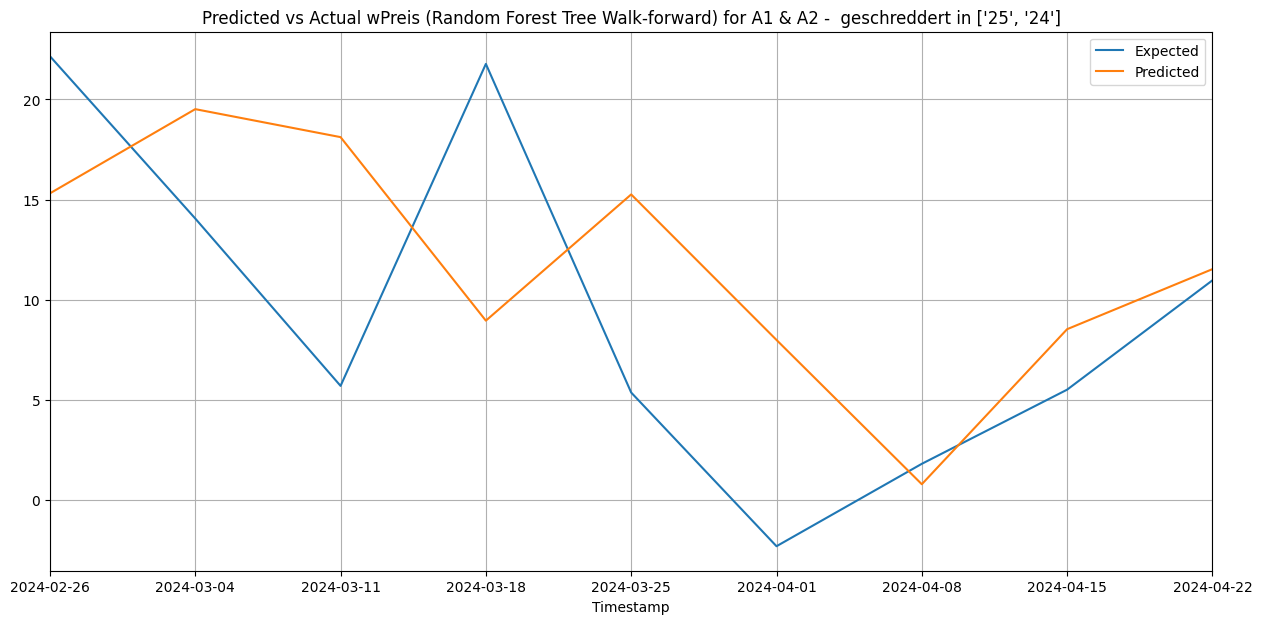

In [132]:
# evaluate
# mae, me, rmse, y, yhat, direction_accuracy = xgb_walk_forward_validation(xgb_data, 6)

wf_accuracy_prod = xgb_walk_forward_validation(xgb_data, nobs)
mae = wf_accuracy_prod['mae']
me = wf_accuracy_prod['me']
rmse = wf_accuracy_prod['rmse']
expected = wf_accuracy_prod['expected']
predictions = wf_accuracy_prod['predictions']
direction_accuracy = wf_accuracy_prod['direction_accuracy']


print(f'Forecast Accuracy (XGBoost Walk-forward) for {df_test["full"].iloc[0]} in {df_test["Plz"].iloc[0]}')
print('MAE: %.3f' % mae)
print('ME: %.3f' % me)
print('RMSE: %.3f' % rmse)
print('Direction Accuracy: %.3f' % direction_accuracy)
# plot expected vs preducted

df_wPreis = pd.DataFrame(
    {'observations': expected,
     'forecast': predictions, 
    })
df_wPreis.index = df_test['wPreis'].index


plt.figure(figsize=(15, 7))

# Plot actual wPreis
ax1 = df_wPreis.observations.plot(grid=True, label='Expected')

# Plot predicted wPreis on secondary y-axis
# ax2 = df_wPreis.forecast.plot(grid=True, secondary_y=True, label='Predicted wPreis')
ax2 = df_wPreis.forecast.plot(grid=True, label='Predicted')

# Set x-axis ticks and labels to be the dates from the index
ax1.set_xticks(df_wPreis.index)
ax1.set_xticklabels(df_wPreis.index.strftime('%Y-%m-%d'))  # Format dates as desired

ax1.legend(loc=1)
ax2.legend(loc=2)
plt.title(f'Predicted vs Actual wPreis (Random Forest Tree Walk-forward) for {df_test["full"].iloc[0]} in {df_test["Plz"].iloc[0]}')
plt.xlabel("Timestamp")

plt.grid(True)
plt.legend()
plt.show() 

The metrics are poorer than Static ARIMA but direction accuracy is similar.

In [133]:
wf_results = {
    'mae': [mae],
    'me': [me],
    'rmse': [rmse],
    'direction_accuracy': [direction_accuracy]
}

# Convert the dictionary into a DataFrame
XGB_wf = pd.DataFrame(wf_results)
XGB_wf

,mae,me,rmse,direction_accuracy
0,6.92263,2.32837,8.226339,0.5


In [134]:
%store XGB_wf


Stored 'XGB_wf' (DataFrame)


## Rolling forecast with XGBoost  

Since this method uses 4 lagged values as input for predicting the next step, we are exposing the test data set in every iteration. So essentially this is a forecast with a window of "input" moving along the test set, predicting one step at a time, but having been trained on the original training set only once.

In [135]:
train, test = train_test_split(xgb_data, nobs)
train = asarray(train)
trainX, trainy = train[:, :-1], train[:, -1]



In [136]:
model_xgb_rolling = XGBRegressor(random_state=42)
model_xgb_rolling.fit(trainX, trainy)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [137]:
predictions = list()
direction_accuracies = list() 

In [138]:
for i in range(len(test)):
    # split test row into input and output columns
    testX, testy = test[i, :-1], test[i, -1]
    # ONLY MAKE ONE-STEP PREDICTIONS BASED ON MODEL TRAINED ONCE 
    print(testX)
    yhat = model_xgb_rolling.predict([testX])
    # store forecast in list of predictions
    predictions.append(yhat[0])
    if i > 0:  # Direction accuracy is not applicable for the first prediction
            forecast_diff = yhat - predictions[-2]
            actual_diff = testy - test[i - 1, -1]
            direction_accuracy = int(np.sign(forecast_diff) == np.sign(actual_diff))
            direction_accuracies.append(direction_accuracy)
    # summarize progress
    print('>expected=%.1f, predicted=%.1f' % (testy, yhat))


[14.94494128 13.7571362  17.34321268 19.08385688]
>expected=22.2, predicted=15.3
[13.7571362  17.34321268 19.08385688 22.15590367]
>expected=14.1, predicted=19.9
[17.34321268 19.08385688 22.15590367 14.05657364]
>expected=5.7, predicted=18.0
[19.08385688 22.15590367 14.05657364  5.70419682]
>expected=21.8, predicted=9.0
[22.15590367 14.05657364  5.70419682 21.77178067]
>expected=5.4, predicted=14.7
[14.05657364  5.70419682 21.77178067  5.37221127]
>expected=-2.3, predicted=7.0
[ 5.70419682 21.77178067  5.37221127 -2.29737704]
>expected=1.8, predicted=0.1
[21.77178067  5.37221127 -2.29737704  1.8152799 ]
>expected=5.5, predicted=5.6
[ 5.37221127 -2.29737704  1.8152799   5.51596431]
>expected=11.0, predicted=9.5


In [139]:
mae = mean_absolute_error(test[:, -1], predictions)
me = np.mean(predictions - test[:, -1])  # Mean Error
rmse = mean_squared_error(test[:, -1], predictions, squared=False)
overall_direction_accuracy = np.mean(direction_accuracies)

#return error, me, rmse ,test[:, -1], predictions, overall_direction_accuracy 

Forecast Accuracy (XGBoost Rolling) for A1 & A2 -  geschreddert in ['25', '24']
MAE: 6.623
ME: 1.549
RMSE: 7.975
Direction Accuracy: 0.500


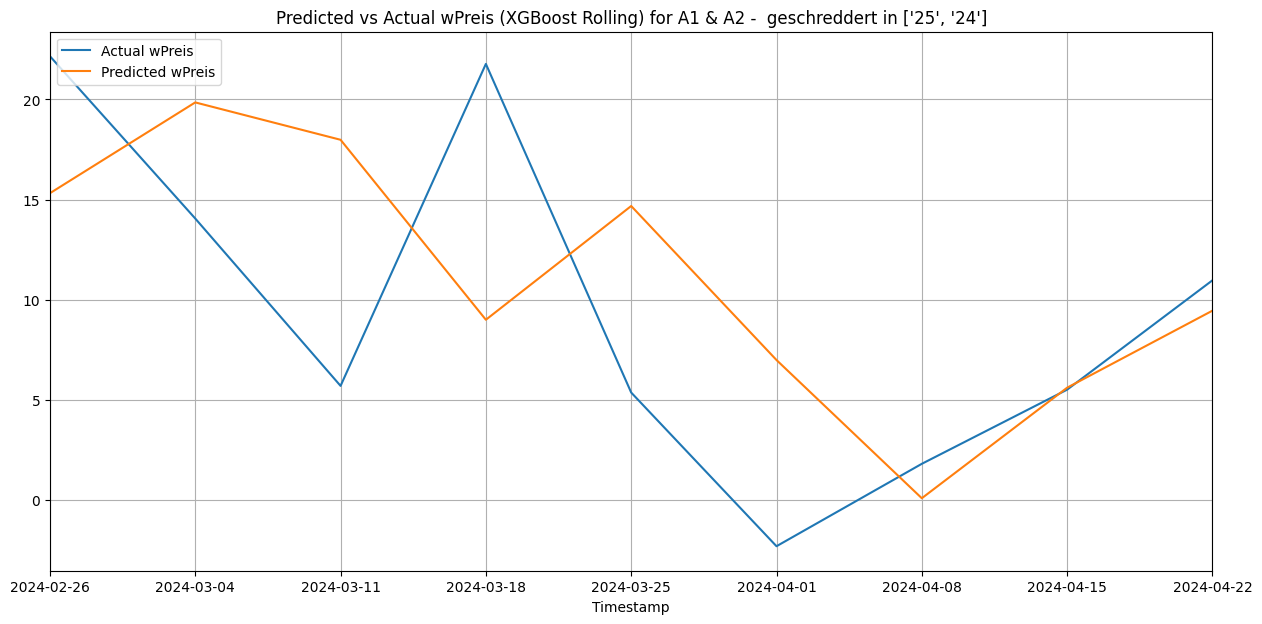

In [140]:
#print('MAE: %.3f' % mae)
print(f'Forecast Accuracy (XGBoost Rolling) for {df_test["full"].iloc[0]} in {df_test["Plz"].iloc[0]}')
print('MAE: %.3f' % mae)
print('ME: %.3f' % me)
print('RMSE: %.3f' % rmse)
print('Direction Accuracy: %.3f' % overall_direction_accuracy)
# plot expected vs preducted

# evaluate
df_wPreis = pd.DataFrame(
    {'observations': test[:, -1],
     'forecast': predictions, 
    })
df_wPreis.index = df_test['wPreis'].index

# plot expected vs preducted
plt.figure(figsize=(15, 7))
plt.title(f'Predicted vs Actual wPreis (XGBoost Rolling) for {df_test["full"].iloc[0]} in {df_test["Plz"].iloc[0]}')
# plt.plot(test[:, -1], label='Expected')
# plt.plot(predictions, label='Predicted')
# Plot actual wPreis
ax1 = df_wPreis.observations.plot(grid=True, label='Actual wPreis')

# Plot predicted wPreis on secondary y-axis
# ax2 = df_wPreis.forecast.plot(grid=True, secondary_y=True, label='Predicted wPreis')
ax2 = df_wPreis.forecast.plot(grid=True, label='Predicted wPreis')

# Set x-axis ticks and labels to be the dates from the index
ax1.set_xticks(df_wPreis.index)
ax1.set_xticklabels(df_wPreis.index.strftime('%Y-%m-%d'))  # Format dates as desired
plt.xlabel("Timestamp")

ax1.legend(loc=1)
ax2.legend(loc=2)
plt.grid(True)

plt.show()

Here the ME is less but RMSE is higher. And Direction Accuracy is lower.

In [141]:
roll_results = {
    'mae': [mae],
    'me': [me],
    'rmse': [rmse],
    'direction_accuracy': [overall_direction_accuracy]
}

# Convert the dictionary into a DataFrame
XGB_roll = pd.DataFrame(roll_results)
XGB_roll

,mae,me,rmse,direction_accuracy
0,6.623338,1.548795,7.974943,0.5


In [142]:
%store XGB_roll


Stored 'XGB_roll' (DataFrame)


## Static (Multi-step) Forecast

Since the above methods use the 4-week lagged values as inputs, it is not possible to use the same method to do static (multi-step) forecasting. For this, we will need to train the model on the original training dataset, not expose it to the test data set and ask it to predict for 6 steps ahead. 

This can be achieved using the ForecasterAutoreg class from the SKforecast package. This class turns any regressor compatible with the scikit-learn API into a
recursive autoregressive (multi-step) forecaster.

In [143]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg

In [144]:
forecaster_xgb = ForecasterAutoreg(
                    regressor = XGBRegressor(random_state=963),
                    lags      = 4
                )

In [145]:
y_train = df_train['wPreis']
forecaster_xgb.fit(y=y_train) # Check if the prep X y is done inside the function 
predicted_test = forecaster_xgb.predict(steps = len(df_test))

In [146]:
def forecast_accuracy(forecast, actual):
      mae = mean_absolute_error(actual, forecast)
      me = np.mean(forecast - actual) 
      me = np.mean(forecast - actual)             # ME
      rmse = np.mean((forecast - actual)**2)**.5  # RMSE
      # Direction accuracy
      forecast_diff = np.diff(forecast)
      actual_diff = np.diff(actual)
      direction_accuracy = np.mean(np.sign(forecast_diff) == np.sign(actual_diff))
    
      return {'mae': mae, 'me': me, 'rmse': rmse, 'direction_accuracy': direction_accuracy}


In [147]:
predicted_test.index = df_test.index
def adjust(val, length= 6): return str(val).ljust(length) # length
print(f'Forecast Accuracy (XGBoost static) for {df_test["full"].iloc[0]} in {df_test["Plz"].iloc[0]}')
stat_accuracy_prod = forecast_accuracy(predicted_test, df_test['wPreis'])
print('MAE: %.3f' % stat_accuracy_prod['mae'])
print('ME: %.3f' % stat_accuracy_prod['me'])
print('RMSE: %.3f' % stat_accuracy_prod['rmse'])
print('Direction Accuracy: %.3f' % stat_accuracy_prod['direction_accuracy'])




Forecast Accuracy (XGBoost static) for A1 & A2 -  geschreddert in ['25', '24']
MAE: 10.741
ME: 7.736
RMSE: 12.012
Direction Accuracy: 0.375


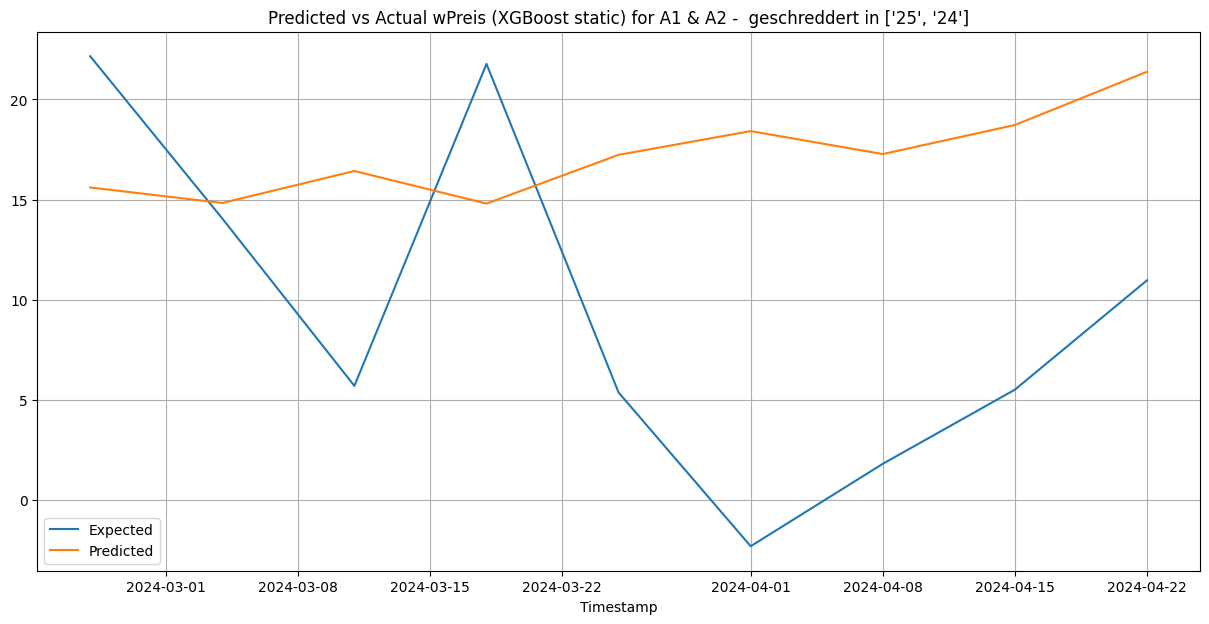

In [148]:
# plot expected vs preducted

plt.figure(figsize=(15, 7))
plt.xlabel("Timestamp")
plt.plot(df_test['wPreis'], label='Expected')
plt.plot(predicted_test, label='Predicted')
plt.title(f'Predicted vs Actual wPreis (XGBoost static) for {df_test["full"].iloc[0]} in {df_test["Plz"].iloc[0]}')
plt.legend()
plt.grid(True)
plt.show()

# plt.plot(df_test['wPreis'], label='Expected')
# plt.plot(predicted_test, label='Predicted')
# plt.legend()
# plt.show()

In [149]:
XGB_static = pd.DataFrame([stat_accuracy_prod])
XGB_static



,mae,me,rmse,direction_accuracy
0,10.741105,7.736472,12.012174,0.375


In [150]:
%store XGB_static


Stored 'XGB_static' (DataFrame)


## All other clusters and categories 

In [151]:

def static_forecast(data):
    category = data['full'].unique()
    cluster = data['Plz'].unique()
    splitratio = 0.05
    nobs = round(len(data)*splitratio)

    df_train, df_test = data[0:-nobs], data[-nobs:]


    forecaster_xgb = ForecasterAutoreg(
                    regressor = XGBRegressor(random_state=963),
                    lags      = 4
                )

    y_train = df_train['wPreis']
    forecaster_xgb.fit(y=y_train)
    predicted_test = forecaster_xgb.predict(steps = len(df_test))
    predicted_test.index = df_test.index
    
    return forecast_accuracy(predicted_test, df_test['wPreis'])

In [152]:

def rolling_forecast(data):
    category = data['full'].unique()
    cluster = data['Plz'].unique()
    splitratio = 0.05
    nobs = round(len(data)*splitratio)

    X = data["wPreis"].values.reshape(-1, 1)

    rf_data = series_to_supervised(X, n_in=4)


    train, test = train_test_split(rf_data, nobs)
    train = asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]


    model_xgb_rolling = XGBRegressor(random_state=42)
    model_xgb_rolling.fit(trainX, trainy)

    predictions = list()
    direction_accuracies = list()   

    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # ONLY MAKE ONE-STEP PREDICTIONS BASED ON MODEL TRAINED ONCE 
        # print(testX)
        yhat = model_xgb_rolling.predict([testX])
        # store forecast in list of predictions
        predictions.append(yhat)
        if i > 0:  # Direction accuracy is not applicable for the first prediction
                forecast_diff = yhat - predictions[-2]
                actual_diff = testy - test[i - 1, -1]
                direction_accuracy = int(np.sign(forecast_diff) == np.sign(actual_diff))
                direction_accuracies.append(direction_accuracy)
    

    mae = mean_absolute_error(test[:, -1], predictions)
    me = np.mean(predictions - test[:, -1])  # Mean Error
    rmse = mean_squared_error(test[:, -1], predictions, squared=False)
    overall_direction_accuracy = np.mean(direction_accuracies)

    return {'mae': mae, 'me': me, 'rmse': rmse, 'direction_accuracy': overall_direction_accuracy}

In [153]:
def wf_forecast(data):
    category = data['full'].unique()
    cluster = data['Plz'].unique()
    splitratio = 0.05
    nobs = round(len(data)*splitratio)

    X = data["wPreis"].values.reshape(-1, 1)

    dt_data = series_to_supervised(X, n_in=4)

    # print(f'Decision Tree Walk-forward forecast Accuracy of: wPreis in {cluster} for {category}')
    wf_accuracy_prod = xgb_walk_forward_validation(dt_data, nobs)
    # mae, me, rmse, y, yhat, direction_accuracy = 
    return wf_accuracy_prod

In [154]:
clusters = df['Plz'].unique() 
datasets = []
for cluster in clusters:
    ds = df[(df['Plz'] == cluster)]
    categories = ds['full'].unique()
    for category in categories:
        datasets.append(ds[ds['full'] == category])

In [155]:
import warnings

# Filter out the specific warning
warnings.filterwarnings('ignore')
data = []
# Loop through each category
for dataset in datasets:
    static_forecast(dataset)
    rolling_forecast(dataset)
    wf_forecast(dataset)
    static_results = static_forecast(dataset)
    rolling_results = rolling_forecast(dataset)
    wf_results = wf_forecast(dataset)
    
    # Create a dictionary to store the results
    results_dict = {
        'Cluster': dataset['Plz'].iloc[0],   
        'Category': dataset['full'].iloc[0],   
        'XGB_mae': static_results['mae'],
        'XGB_static_me': static_results['me'],
        'XGB_static_rmse': static_results['rmse'],
        'XGB_static_direction_accuracy': static_results['direction_accuracy'],
        'XGB_rolling_mae': rolling_results['mae'],
        'XGB_rolling_me': rolling_results['me'],
        'XGB_rolling_rmse': rolling_results['rmse'],
        'XGB_rolling_direction_accuracy': rolling_results['direction_accuracy'],
        'XGB_wf_mae': wf_results['mae'],
        'XGB_wf_me': wf_results['me'],
        'XGB_wf_rmse': wf_results['rmse'],
        'XGB_wf_direction_accuracy': wf_results['direction_accuracy']
    }
    
    # Append the dictionary to the list
    data.append(results_dict)

# Create a DataFrame from the list of dictionaries
df_results = pd.DataFrame(data)

# Print the DataFrame
# df_results

In [ ]:
XGBresults = df_results
%store XGBresults

In [156]:
df_results.to_csv('XGB_Results.csv')

In [157]:
df_metrics = df_results[['Cluster', 'Category', 'XGB_static_rmse', 'XGB_rolling_rmse',  'XGB_wf_rmse', 'XGB_static_direction_accuracy', 'XGB_rolling_direction_accuracy', 'XGB_wf_direction_accuracy']]


In [158]:
def getRMSEplot(df_plot):
    # Create subplots
    fig, ax = plt.subplots()

    # Define bar width
    bar_width = 0.25

    # Define the positions for the bars
    clusters = df_plot['Cluster']
    static_rmse = df_plot['XGB_static_rmse']
    rolling_rmse = df_plot['XGB_rolling_rmse']
    wf_rmse = df_plot['XGB_wf_rmse']
    ind = range(len(clusters))

    # Plot the bars
    ax.barh(ind, static_rmse, bar_width, label='Static RMSE')
    ax.barh([x + bar_width for x in ind], rolling_rmse, bar_width, label='Rolling RMSE')
    ax.barh([x + 2*bar_width for x in ind], wf_rmse, bar_width, label='Walk-forward RMSE')

    # Add RMSE values next to each bar
    for i, (s_rmse, r_rmse, wf_rmse) in enumerate(zip(static_rmse, rolling_rmse, wf_rmse)):
        ax.text(s_rmse, i, f'{s_rmse:.2f}', ha='right', va='center')
        ax.text(r_rmse, i + bar_width, f'{r_rmse:.2f}', ha='right', va='center')
        ax.text(wf_rmse, i + 2*bar_width, f'{wf_rmse:.2f}', ha='right', va='center')

    # Set labels and title
    ax.set_xlabel('RMSE')
    ax.set_ylabel('Cluster')
    ax.set_title(f'RMSE comparison of Static, Rolling and Walk-forward XGBoost across clusters for {df_plot["Category"].iloc[0]}')


    # Set yticks and labels
    ax.set_yticks(ind)
    ax.set_yticklabels(df_plot['Cluster'])

    # Move legend outside the graph
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))   # Add legend

    # Show plot
    plt.show()

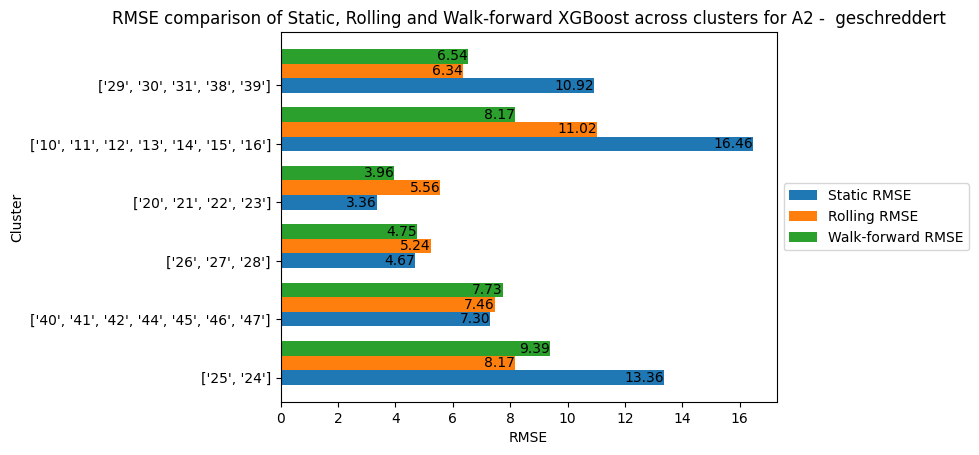

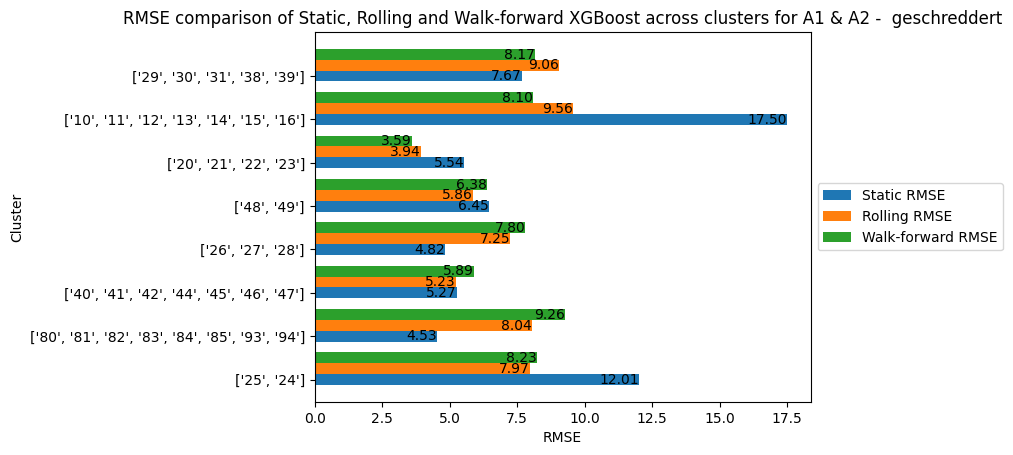

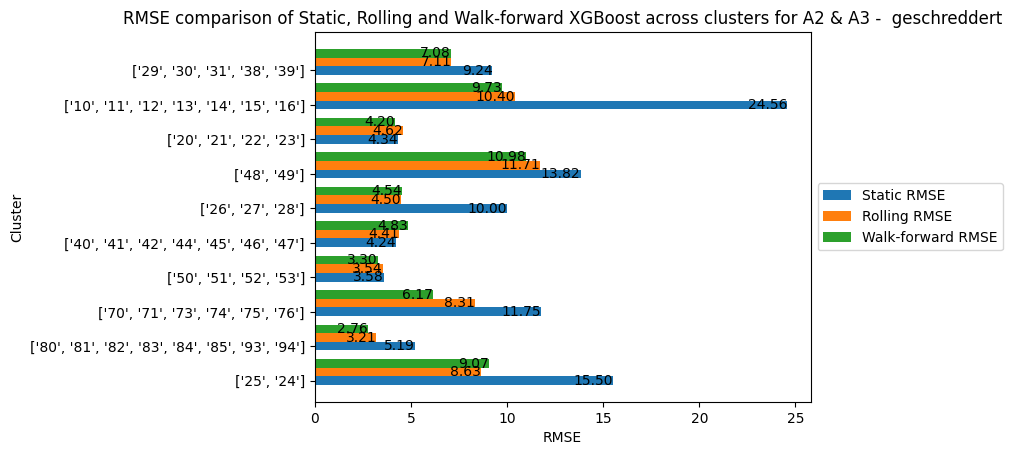

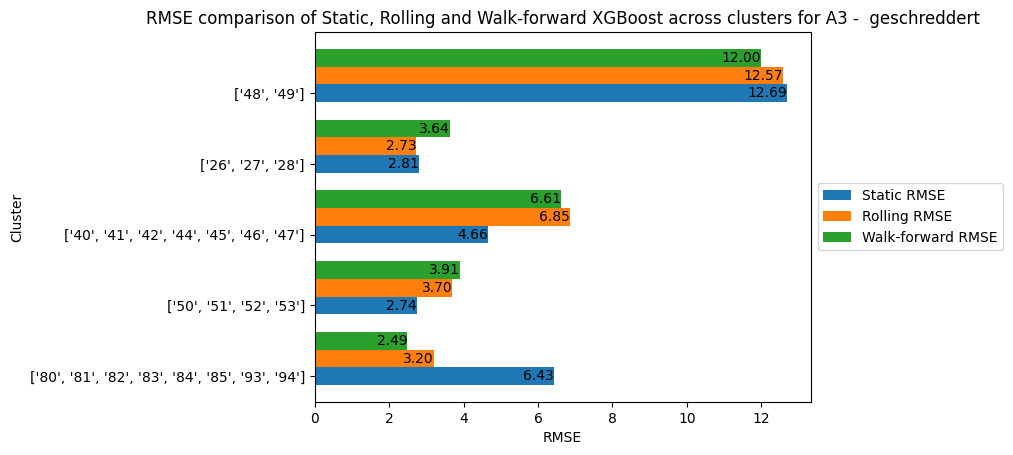

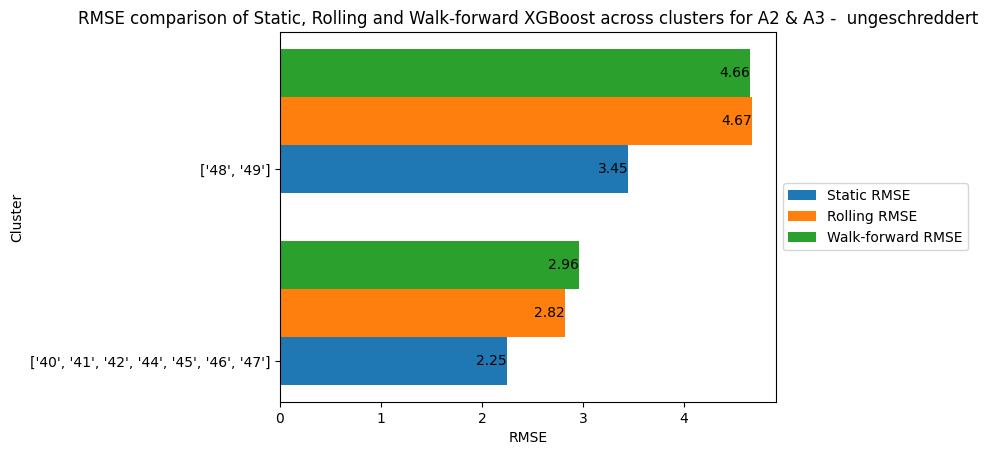

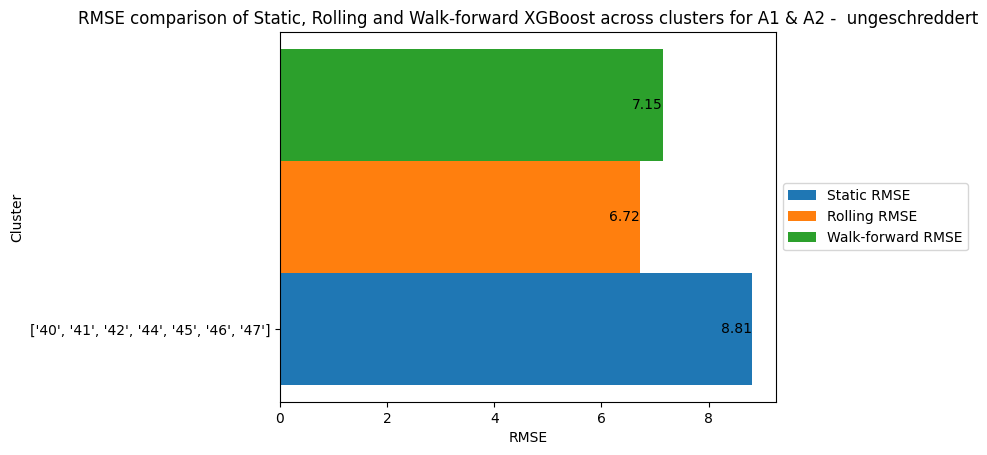

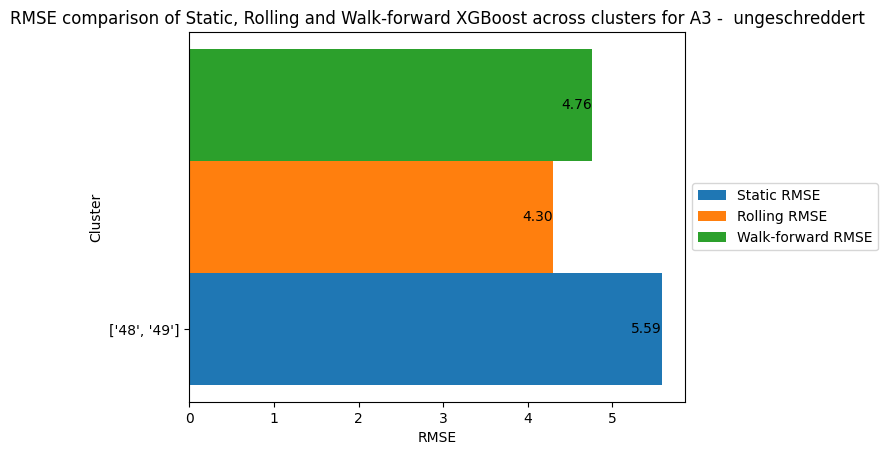

In [159]:
for category in df_metrics['Category'].unique():
    filtered = df_metrics[df_metrics['Category'] == category]
    getRMSEplot(filtered)


In [162]:
def getDirAccplot(df_plot):
    # Create subplots
    fig, ax = plt.subplots()

    # Define bar width
    bar_width = 0.25

    # Define the positions for the bars
    clusters = df_plot['Cluster']
    static_acc = df_plot['XGB_static_direction_accuracy']
    rolling_acc = df_plot['XGB_rolling_direction_accuracy']
    wf_acc = df_plot['XGB_wf_direction_accuracy']
    ind = range(len(clusters))

    # Plot the bars
    ax.barh(ind, static_acc, bar_width, label='Static Direction Accuracy')
    ax.barh([x + bar_width for x in ind], rolling_acc, bar_width, label='Rolling Direction Accuracy')
    ax.barh([x + 2*bar_width for x in ind], wf_acc, bar_width, label='Walk-forward Direction Accuracy')

    # Add direction accuracy values next to each bar
    for i, (s_dir_acc, r_dir_acc, wf_dir_acc) in enumerate(zip(static_acc, rolling_acc, wf_acc)):
        ax.text(s_dir_acc, i, f'{s_dir_acc:.2f}', ha='right', va='center')
        ax.text(r_dir_acc, i + bar_width, f'{r_dir_acc:.2f}', ha='right', va='center')
        ax.text(wf_dir_acc, i + 2*bar_width, f'{wf_dir_acc:.2f}', ha='right', va='center')

    # Set labels and title
    ax.set_xlabel('Direction Accuracy')
    ax.set_ylabel('Cluster')
    ax.set_title(f'Direction accuracy comparison of Static, Rolling and Walk-forward XGBoost across clusters for {df_plot["Category"].iloc[0]}')


    # Set yticks and labels
    ax.set_yticks(ind)
    ax.set_yticklabels(df_plot['Cluster'])

    # Move legend outside the graph
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    # Show plot
    plt.show()

In [163]:
 # MUST SHOW DIR ACC VALUES NEXT TO THE BARS 

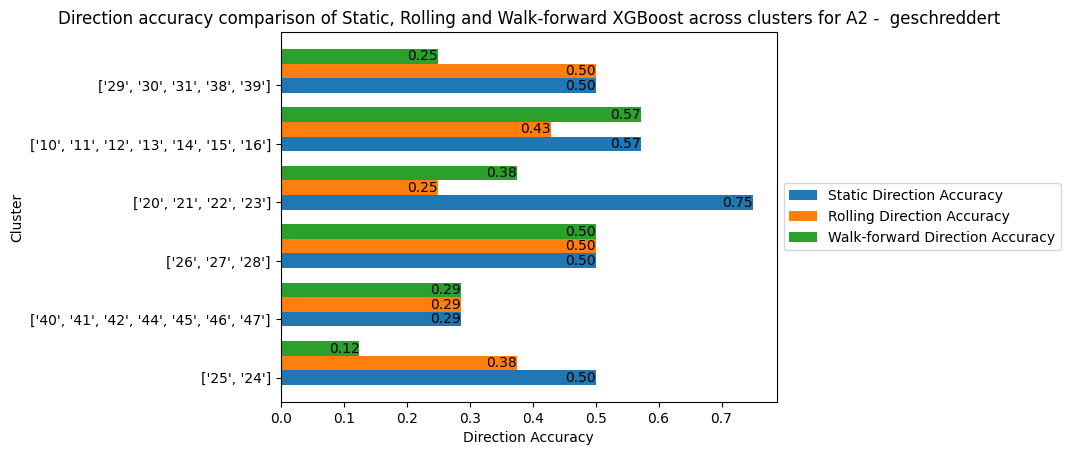

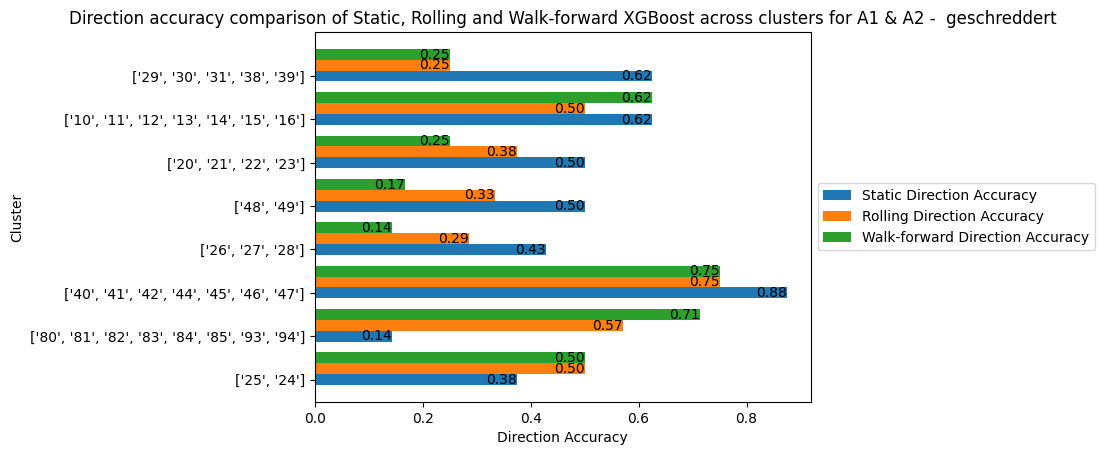

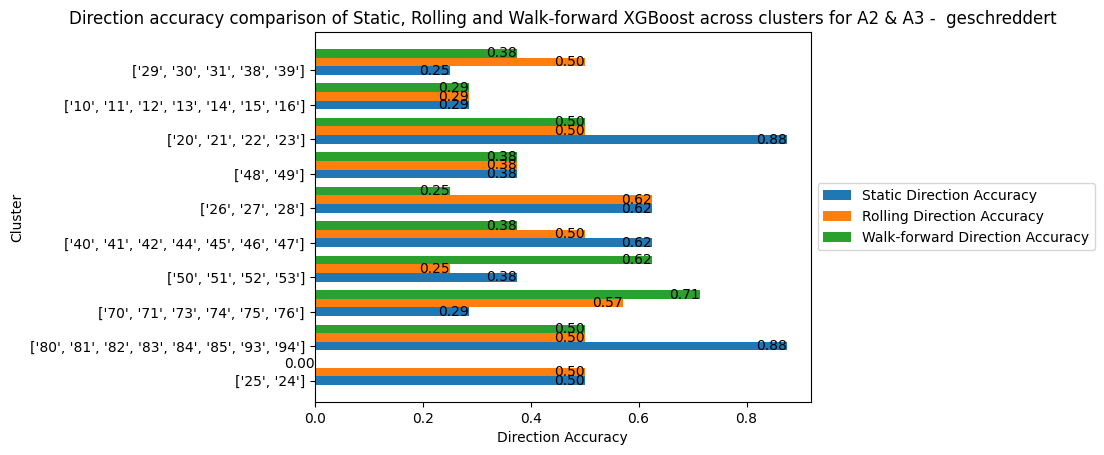

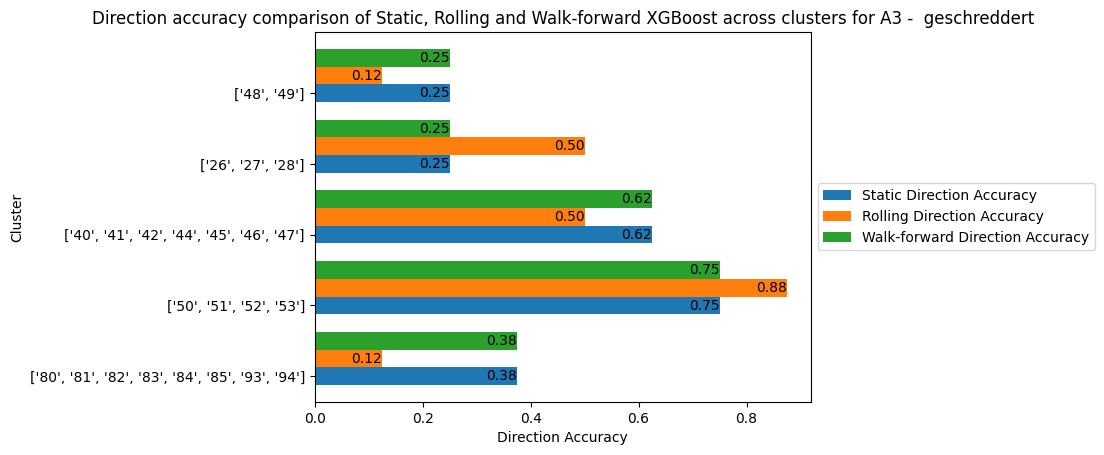

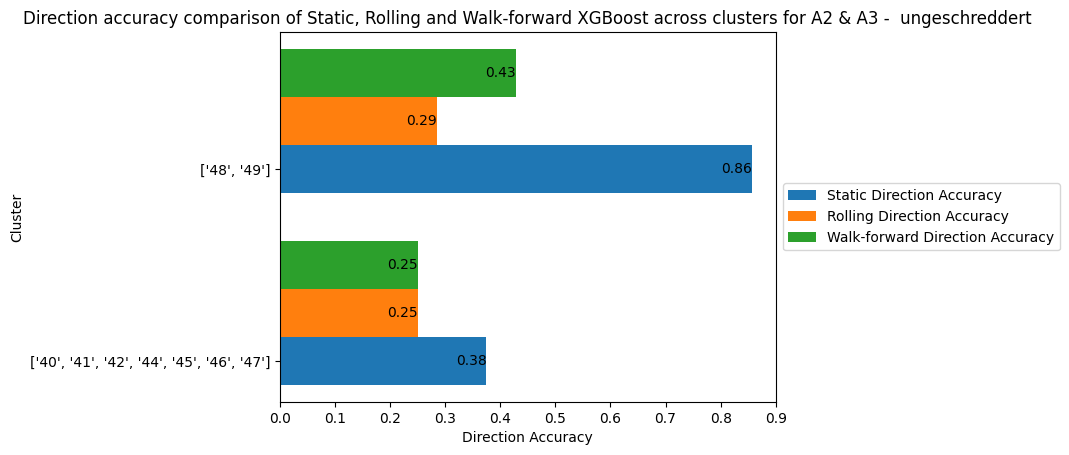

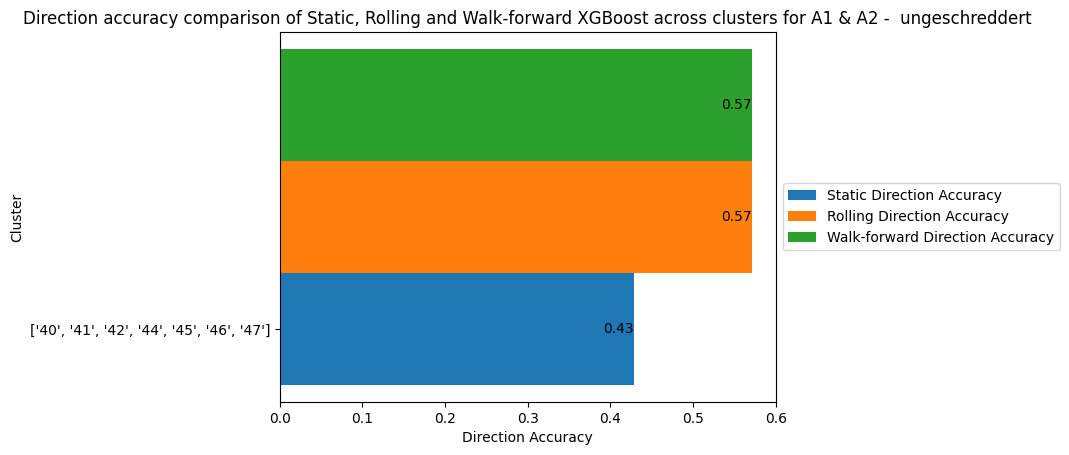

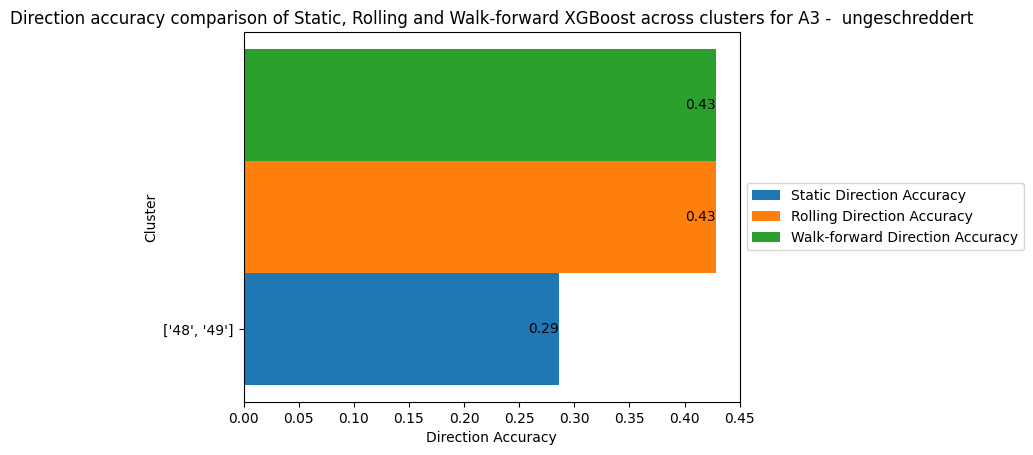

In [164]:
for category in df_metrics['Category'].unique():
    filtered = df_metrics[df_metrics['Category'] == category]
    getDirAccplot(filtered)


PLOTLY GRAPHS FOR THE SAME

In [165]:

# def getRMSEplot(df_plot):
#     traces = []
#     for metric in ['XGB_static_rmse', 'XGB_rolling_rmse',  'XGB_wf_rmse']:
#         trace = go.Bar(
#             x= df_plot[metric],
#             y= df_plot['Cluster'], 
#             name=metric,
#             orientation='h'
#         )
#         traces.append(trace)

#     # Define layout
#     layout = go.Layout(
#         title= f'Comparison of XGBoost RMSE for Static, Rolling and Walk-forward Validation across Clusters for {df_plot["Category"].iloc[0]}',
#         xaxis=dict(title='RMSE'),
#         yaxis=dict(title='Cluster'),
#         barmode='group'
#     )

#     # Create figure
#     fig = go.Figure(data=traces, layout=layout)

#     # Show figure
#     fig.show()



In [166]:
# def getDirAccplot(df_plot):
#     traces = []
#     for metric in ['XGB_static_direction_accuracy', 'XGB_rolling_direction_accuracy', 'XGB_wf_direction_accuracy']:
#         trace = go.Bar(
#             x= df_plot[metric],
#             y= df_plot['Cluster'], 
#             name=metric,
#             orientation='h'
#         )
#         traces.append(trace)

#     # Define layout
#     layout = go.Layout(
#         title= f'Comparison of Direction Accuracy using XGBoost between Static, Rolling and Walk-Forward across Clusters for {df_plot["Category"].iloc[0]}',
#         xaxis=dict(title='Direction Accuracy'),
#         yaxis=dict(title='Cluster'),
#         barmode='group'
#     )

#     # Create figure
#     fig = go.Figure(data=traces, layout=layout)

#     # Show figure
#     fig.show()

In [167]:
# for category in df_metrics['Category'].unique():
#     filtered = df_metrics[df_metrics['Category'] == category]
#     getRMSEplot(filtered)
#     getDirAccplot(filtered)
